<a href="https://colab.research.google.com/github/Samurarahman/CSE475/blob/main/Ensemble_learning_and_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ensemble learning and XAI**
**Ensemble Learning** is a machine learning approach that combines predictions from multiple models to improve accuracy and reliability, using methods like Bagging (reducing variance), Boosting (reducing bias), and Stacking(combining diverse models). It enhances performance by leveraging the strengths of individual models. Explainable AI (XAI), on the other hand, aims to make AI systems transparent and understandable by providing insights into how models make decisions. Using techniques like SHAP, LIME, and feature importance analysis, XAI helps build trust, enables debugging, and ensures AI solutions align with ethical standards and user expectations.

# Loading Libraries

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Loading the Dataset

In [19]:
df1 = pd.read_csv('/content/drive/MyDrive/CSE475/Ensemble learning and XAI/cw_22_23_24.csv')
df1.head()

,adm_type,shift_from,ssc,yr_nae,m_no,mrn,pt_name,sex,disease,D.O.A,D.O.D,status,consultant,L.O.S
0,Shift From,ER,No,1,1,21845698,Hara Bibi,F,STEMI,1-Jan-22,1-Jan-22,Discharge,Imran Khan,0
1,Shift From,ER,No,2,2,22000071,Taj Rehman,M,ADHF,1-Jan-22,5-Jan-22,Discharge,Malik Faisal,4
2,Shift From,ER,No,3,3,21838760,Bakhtawar Shah,M,ihd,1-Jan-22,10-Jan-22,Discharge,Asif Iqbal,9
3,Shift From,ER,No,4,4,22000251,Arasal Jan Bibi,F,NaN,1-Jan-22,7-Jan-22,Discharge,Sher Bahadar,6
4,Shift From,Neu,No,5,5,21825110,Khad Mewa,F,NaN,1-Jan-22,2-Jan-22,Discharge,Tariq Nawaz,1


In [32]:
unique_values = df1['status'].unique()
print(unique_values)

['Discharge' 'Expire' 'Shifted' 'DOW' 'LAMA']


In [33]:
df = df1.drop(columns=['yr_nae','mrn', 'pt_name', 'consultant'])
df.head()

,adm_type,shift_from,ssc,m_no,sex,disease,D.O.A,D.O.D,status,L.O.S
0,Shift From,ER,No,1,F,STEMI,1-Jan-22,1-Jan-22,Discharge,0
1,Shift From,ER,No,2,M,ADHF,1-Jan-22,5-Jan-22,Discharge,4
2,Shift From,ER,No,3,M,ihd,1-Jan-22,10-Jan-22,Discharge,9
3,Shift From,ER,No,4,F,NaN,1-Jan-22,7-Jan-22,Discharge,6
4,Shift From,Neu,No,5,F,NaN,1-Jan-22,2-Jan-22,Discharge,1


# Data Preprocessing
Handle missing values, if any.Encode categorical variables.Feature scaling (if necessary)

In [34]:
X = df.drop(['status'], axis=1)
print(X)
#This operation reduces each class label by 1, assuming
#class labels originally start from 1. If classes were
#initially numbered as 1, 2, 3, etc., they’ll now be 0, 1, 2, etc.



#Many machine learning algorithms in Python
#(especially in libraries like scikit-learn)
#expect class labels to start from 0. This
#adjustment simplifies compatibility with
#these algorithms and avoids indexing issues.
# y = df['loan_status']-1
y = df['status']

#Identifying Feature Types:

# Split the features into categorical and numerical

#Selects the columns containing categorical data
categorical_features = X.select_dtypes(include=['object']).columns

#Selects columns containing numerical data
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


#Data Preprocessing:

# Standard scaling for numerical features only

#will adjust the data so that each feature has
#a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()

#first learns the mean and standard deviation for
#each numerical feature in X.
#This helps ensure that all numerical features are on a similar scale.

#this process centers the data around zero and adjusts the scale,
#which often improves the performance of machine learning models
#by preventing any one feature from dominating due to its larger scale.
scaled_numerical_data = scaler.fit_transform(X[numerical_features])

# One-hot encoding for categorical features only

#The OneHotEncoder converts categorical variables
#into binary (one-hot) encoded variables.
encoder = OneHotEncoder(drop='first')
encoded_categorical_data = encoder.fit_transform(X[categorical_features])

# Concatenate the scaled numerical and encoded categorical data

#Concatenates the scaled numerical and encoded categorical arrays horizontally,
#combining them into a single dataset.
processed_data = np.hstack([scaled_numerical_data, encoded_categorical_data.toarray()])

# Convert to DataFrame with appropriate column names
final_columns = numerical_features.tolist() + encoder.get_feature_names_out(categorical_features).tolist()
final_df = pd.DataFrame(processed_data, columns=final_columns)

#Stores the preprocessed features in data_X for modeling
data_X = final_df.copy()

        adm_type shift_from  ssc  m_no sex disease      D.O.A      D.O.D  \
0     Shift From         ER   No     1   F   STEMI   1-Jan-22   1-Jan-22   
1     Shift From         ER   No     2   M    ADHF   1-Jan-22   5-Jan-22   
2     Shift From         ER   No     3   M     ihd   1-Jan-22  10-Jan-22   
3     Shift From         ER   No     4   F     NaN   1-Jan-22   7-Jan-22   
4     Shift From        Neu   No     5   F     NaN   1-Jan-22   2-Jan-22   
...          ...        ...  ...   ...  ..     ...        ...        ...   
9568  Shift From         ER  yes   323   F     PPM  30-Jun-24   5-Jul-24   
9569  Shift From         ER  yes   324   F     CAD  30-Jun-24   4-Jul-24   
9570  Shift From         ER  yes   325   M      MI  30-Jun-24   4-Jul-24   
9571  Shift From         ER  yes   326   M    PPCI  30-Jun-24   1-Jul-24   
9572  Shift From  Post Cath  yes   327   F    AWMI  30-Jun-24   1-Jul-24   

      L.O.S  
0         0  
1         4  
2         9  
3         6  
4         1  
...

In [35]:
'''ya = df['status']
print(ya)'''

"ya = df['status']\nprint(ya)"

In [36]:
data_X.head()

,m_no,L.O.S,adm_type_IBP,adm_type_OPD,adm_type_OPD,adm_type_Shift From,adm_type_opd,shift_from_AMU-F,shift_from_AMU-M,shift_from_AMU/ER,...,D.O.D_9-Mar-24,D.O.D_9-May-22,D.O.D_9-May-23,D.O.D_9-May-24,D.O.D_9-Nov-22,D.O.D_9-Nov-23,D.O.D_9-Oct-22,D.O.D_9-Oct-23,D.O.D_9-Sep-22,D.O.D_9-Sep-23
0,-1.710488,-0.938647,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.699782,0.090521,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.689077,1.376981,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.678371,0.605105,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.667666,-0.681355,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The code splits the dataset `X` and labels `y` into training and testing sets, allocating 20% for testing, using a fixed random seed (42) for reproducibility.

In [37]:
X = data_X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bagging Approach: Random Forest

In [38]:
#Random Forest Classifier Initialization
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#Training the Model
rf_model.fit(X_train, y_train)
#Making Predictions
rf_pred = rf_model.predict(X_test)
#Evaluating the Model
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.8913838120104438


# Boosting Approach: Gradient Boosting
This code trains a Gradient Boosting Classifier with 100 estimators, fits it on the training data (X_train, y_train), makes predictions on the test data (X_test), and prints the accuracy of the predictions compared to the true labels (y_test).

In [39]:
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))

Gradient Boosting Accuracy: 0.8903394255874674


# Stacking Approach
Use a meta-classifier (e.g., Logistic Regression) on top of base learners

In [40]:
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

#The stacking model uses a list of base learners—Random Forest,
#Gradient Boosting, and XGBoost classifiers—each with 100 estimators
#and a fixed random state for reproducibility.

# Define base models
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42))
]

# Define meta-learner

# Logistic Regression is chosen as the meta-learner,
#which combines the predictions from the base learners to make final predictions. The meta-learner is often a simpler model (e.g., Logistic Regression or Decision Tree)
#that helps synthesize the information from the base models.
meta_learner = LogisticRegression()

# Set up the stacking model

#This line initializes the stacking classifier,
#which combines the base models and uses the meta-learner
#for final predictions. Cross-validation (cv=5) is
#used within the stacking process to improve robustness.
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)

stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
print("Stacking Model Accuracy:", accuracy_score(y_test, stacking_pred))

# Define meta-learner
meta_learner = LogisticRegression()

# Set up the stacking model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=2)
stacking_model.fit(X_train, y_train)

Stacking Model Accuracy: 0.8986945169712793


StackingClassifier(cv=2,
                   estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              fea...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=LogisticRegression())

# Combine multiple classifiers by voting.
This code creates a soft voting ensemble classifier using three models (Random Forest, Gradient Boosting, and SVC), trains it on the training data (X_train, y_train), makes predictions on the test data (X_test), and prints the accuracy of the predictions against the true labels (y_test).

In [41]:
#This ensemble model combines several base models—Random Forest,
#Gradient Boosting, and Support Vector Classifier (SVC)—to
#make predictions. The voting='soft' parameter indicates that
#the classifier will use the probabilities predicted by each model
#and then average them to make final predictions.
#This "soft voting" often yields better results when
#the models provide probability estimates.


vote_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
        ('svc', SVC(probability=True))
    ],
    voting='soft'
)
vote_model.fit(X_train, y_train)
vote_pred = vote_model.predict(X_test)
print("Voting Classifier Accuracy:", accuracy_score(y_test, vote_pred))


Voting Classifier Accuracy: 0.8981723237597912


# Evaluation
Compare the performance of all models.

In [42]:
print("Random Forest:", accuracy_score(y_test, rf_pred))
print("Gradient Boosting:", accuracy_score(y_test, gb_pred))
print("Stacking Model:", accuracy_score(y_test, stacking_pred))
print("Voting Classifier:", accuracy_score(y_test, vote_pred))


Random Forest: 0.8913838120104438
Gradient Boosting: 0.8903394255874674
Stacking Model: 0.8986945169712793
Voting Classifier: 0.8981723237597912


# Cross-Validation Performance Comparison
Use cross_val_score from sklearn.model_selection to perform cross-validation and evaluate each ensemble model's accuracy across folds.Set cv=5 for 5-fold cross-validation (can be adjusted based on preference or dataset size).

In [43]:
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "Stacking": StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('svc', SVC(probability=True))
        ],
        final_estimator=LogisticRegression()
    ),
    "Voting": VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
            ('svc', SVC(probability=True))
        ],
        voting='soft'
    )
}

# Perform cross-validation and store results

#scores.mean() gives the average accuracy across all folds.
#scores.std() provides the variability in accuracy between the folds.
results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, data_X, y, cv=2, scoring='accuracy')
    results[model_name] = scores
    print(f"{model_name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Random Forest Cross-Validation Accuracy: 0.8953 ± 0.0031
Gradient Boosting Cross-Validation Accuracy: 0.8827 ± 0.0020
Stacking Cross-Validation Accuracy: 0.8992 ± 0.0001
Voting Cross-Validation Accuracy: 0.8954 ± 0.0037


# Visualizing Cross-Validation Results
This code creates a DataFrame results_df to hold cross-validation accuracy scores of different ensemble models, then uses a box plot to visually compare the models' performance by plotting the distribution of accuracy scores for each model, with proper labels and formatting for clarity.

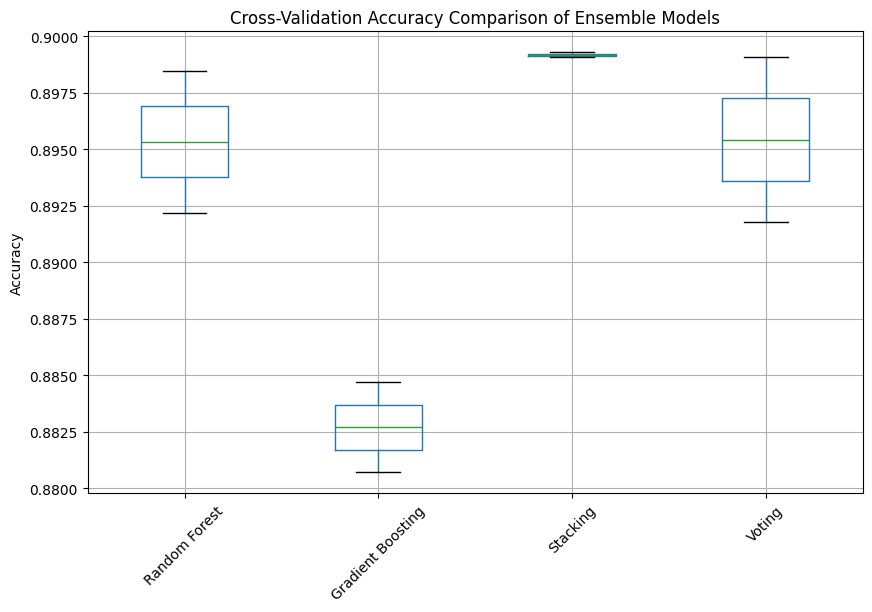

In [44]:
import matplotlib.pyplot as plt

# Prepare results for visualization
import pandas as pd

#converted into a pandas DataFrame (results_df).
#This allows for easier manipulation and visualization.
results_df = pd.DataFrame(results)

# Plot box plot for model comparison
plt.figure(figsize=(10, 6))
results_df.boxplot()
plt.title("Cross-Validation Accuracy Comparison of Ensemble Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


# Confusion Matrix for Each Model

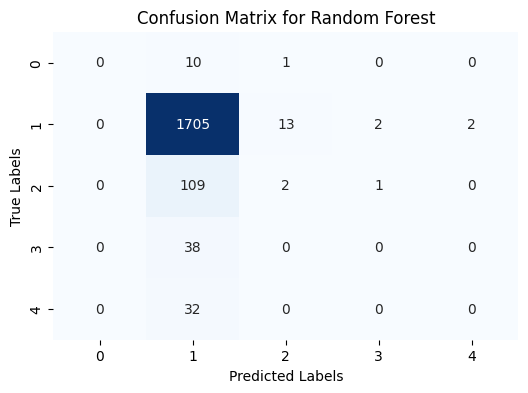

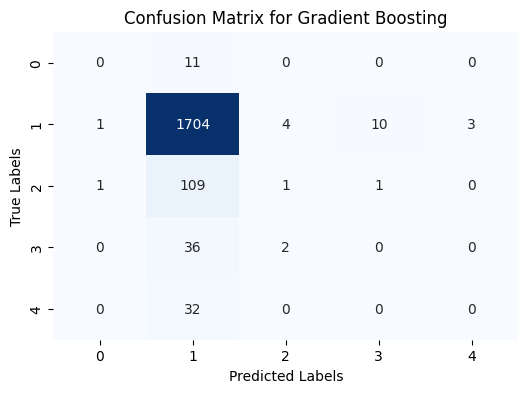

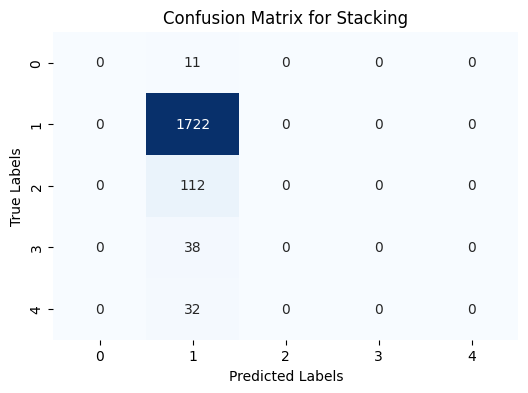

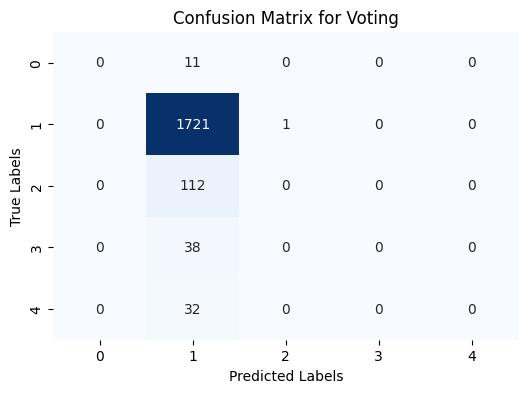

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Fit each model on the training data and plot the confusion matrix for each
for model_name, model in models.items():
    # Fit the model and predict on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


# Precision and Recall for Each Model

In [46]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Fit each model on the training data and calculate precision, recall, and F1-score
for model_name, model in models.items():
    # Fit the model and predict on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the metrics
    print(f"{model_name} Performance Metrics:")
    print(f" - Precision: {precision:.4f}")
    print(f" - Recall: {recall:.4f}")
    print(f" - F1 Score: {f1:.4f}\n")


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Random Forest Performance Metrics:
 - Precision: 0.8168
 - Recall: 0.8914
 - F1 Score: 0.8498

Gradient Boosting Performance Metrics:
 - Precision: 0.8182
 - Recall: 0.8903
 - F1 Score: 0.8489



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Stacking Performance Metrics:
 - Precision: 0.8086
 - Recall: 0.8992
 - F1 Score: 0.8515

Voting Performance Metrics:
 - Precision: 0.8085
 - Recall: 0.8982
 - F1 Score: 0.8510



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Summary of Metrics

# Explainable AI (XAI)

## Explaining Model Predictions Using SHAP
SHAP provides detailed insights into feature contributions for individual predictions and the overall model. We'll compute SHAP values for the Random Forest model as an example, but this approach can be extended to other models as well.

In [1]:
import shap

# Use a subset of the data for SHAP to reduce computation time

#This code uses SHAP to explain the predictions of the Random Forest model
#on a subset of the test data.
X_sample = X_test.sample(100, random_state=42)


# Initialize SHAP explainer for the Random Forest model

#This initializes a TreeExplainer for the Random Forest model. The TreeExplainer is efficient
#for tree-based models (like Random Forest) and computes SHAP values to explain the output of
#individual predictions.
explainer = shap.TreeExplainer(models["Random Forest"])

#This computes the SHAP values for each feature in the sample data.
#The SHAP values represent how much each feature contributes to the difference between the prediction
#and the expected output (mean prediction).
shap_values = explainer.shap_values(X_sample)

NameError: name 'X_test' is not defined

## illustrates the feature importance in terms of the average impact each feature has on the model's predictions

In [ ]:
import numpy as np

# Calculate mean absolute SHAP values across all classes for each feature

#This step calculates the mean absolute SHAP value for each feature.

#The shap_values array contains the SHAP values for all instances in X_sample,
#and by taking the absolute value and averaging across all instances, we get
#an overall measure of each feature's contribution to the model's predictions.

mean_shap_values = np.mean([np.abs(sv) for sv in shap_values], axis=0)  # Resulting shape should be (100, 12) to match X_sample

# If mean_shap_values is (12, 5), take the mean across classes, resulting in a vector (12, )

#If there are multiple classes (for multi-class classification), this line computes the mean
#SHAP value across all classes, collapsing the results to a single value for each feature.

mean_shap_values = np.mean(mean_shap_values, axis=1)



# Repeat this vector to create a matrix that matches X_sample's shape

#This step repeats the mean_shap_values for each row in the sample data.
#This is necessary to create a shape that matches the original X_sample for visualization.
mean_shap_values_repeated = np.tile(mean_shap_values, (X_sample.shape[0], 1))


# Plot the summary plot with the repeated matrix
shap.summary_plot(mean_shap_values_repeated, X_sample, plot_type="bar", feature_names=X_sample.columns)


# Explaining Model Predictions Using LIME

In [ ]:
!pip install lime

# LIME's LimeTabularExplainer provides a simple way to explain individual predictions of a model by approximating it locally with an interpretable model, highlighting the most influential features for that prediction.

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names=data_X.columns, class_names=y.values, mode='classification')

# Choose a sample from the test set to explain
sample_index = 0 # Adjust to analyze a different sample

#Generate the Explanation
#This generates a local explanation for the chosen test instance using the Random Forest model’s predicted probabilities

exp = lime_explainer.explain_instance(X_test.values[sample_index], models["Random Forest"].predict_proba, num_features=10)
print(X_test.values[sample_index])
# Display the explanation
exp.show_in_notebook()
exp.show_in_notebook(show_table=True, show_all=False)


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Choose a valid sample index
sample_index = 6  # Replace with a valid index, or use np.random.randint(0, len(X_test))


# Ensure feature_names and class_names are valid strings
feature_names = final_columns

# Ensure that class names in LIME are ordered the same way as the model output
class_names = [str(cls) for cls in sorted(y.unique())]  # Sorting the class labels to ensure correct order

# Initialize the LIME explainer with the corrected class names
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Generate the explanation again
exp = lime_explainer.explain_instance(
    X_test.values[sample_index],
    models["Random Forest"].predict_proba,
    num_features=10
)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)

# Print the selected sample's feature values
print("\n\nFeature values of the selected sample:")
print(X_test.values[sample_index])

# Get the actual class of the selected sample
actual_class = y_test.values[sample_index]
print(f"Actual class: {actual_class}")

# Get the predicted class of the selected sample
predicted_class = models["Random Forest"].predict(X_test.values[sample_index].reshape(1, -1))[0]
print(f"Predicted class: {predicted_class}")

# Get the predicted probabilities of the selected sample
predicted_probabilities = models["Random Forest"].predict_proba(X_test.values[sample_index].reshape(1, -1))[0]
print(f"Predicted probabilities: {predicted_probabilities}")
